# Application

In this notebook, we apply the day-ahead forecasts for a peak shaving task and compare the results with the achieved metrics.

In [128]:
import pandas as pd
import seaborn as sns
from gurobipy import *
import matplotlib.pyplot as plt
import gurobipy as gp
import numpy as np

import matplotlib.pyplot as pl#t
plt.rcParams.update({'font.size': 22})

In [129]:
### calculate a given mape for a daily df

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# functions

def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    actual = pd.Series(actual)
    forecast = pd.Series(forecast)

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    print(ft_wmape_forecast)
    # return a float
    return "WMAPE",ft_wmape_forecast

def mean_absolute_percentage_error(y_true, y_pred):
    return "MAPE", np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return "MAE",mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    rms = mean_squared_error(y_true, y_pred, squared=False)
    return "RMSE", rms

def mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=True)
    return "MSE", mse

def medae(y_true, y_pred):
    return "MEDAE", median_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return "R2",r2_score(y_true, y_pred)

def msle(y_true, y_pred):
    return "MSLE", mean_squared_log_error(y_true, y_pred)

def maape(y_true,y_pred): # https://www.sciencedirect.com/science/article/pii/S0169207016000121
    EPSILON = 1e-10
    return "MAAPE", np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

### from peak challenge
def get_peak_values_from_loadpatterm(loadpattern):
  peakvalues = []
  for i in range (int(len(loadpattern)/24)):
    to_consider = loadpattern[i*24:(i+1)*24]
    peakvalues.append(np.max(to_consider))
  return np.array(peakvalues)

def get_peak_times_from_loadpattern(loadpattern):
    peaktimes = []
    for i in range (int(len(loadpattern)/24)):
        to_consider = loadpattern[i*24:(i+1)*24]
        peaktimes.append(to_consider.tolist().index(np.max(to_consider)))
    to_return = np.array(peaktimes)
    to_return = to_return+1
    return to_return


def shape_score (actual_loadpattern,predicted_loadpattern):
    normed_peaksurroundings_actual = []
    normed_peaksurroundings_pred = []
    for block_index in range (int(len(actual_loadpattern)/24)):
        startindex= block_index*24
        block_actual = actual_loadpattern[startindex:(block_index+1)*24]
        peakvalue_actual = np.max(block_actual)
        peakindex_actual  = np.where(block_actual == peakvalue_actual)[0][0]
        normed_actual = actual_loadpattern/peakvalue_actual

        block_pred = predicted_loadpattern[startindex:(block_index+1)*24]
        peakvalue_pred = np.max(block_pred)
        normed_pred = predicted_loadpattern/peakvalue_pred


        normed_peaksurroundings_actual.extend(normed_actual[startindex + peakindex_actual-2:startindex +peakindex_actual+3])
        normed_peaksurroundings_pred.extend(normed_pred[startindex+peakindex_actual-2: startindex+ peakindex_actual+3])
    normed_peaksurroundings_actual = np.array(normed_peaksurroundings_actual)
    normed_peaksurroundings_pred = np.array(normed_peaksurroundings_pred)
    absolute_errors = abs(normed_peaksurroundings_actual-normed_peaksurroundings_pred)
    return "shape_score", np.sum(absolute_errors)

def peaktime_score(actual_peaktimes, predicted_peaktimes):
    absolute_diffs = abs(actual_peaktimes-predicted_peaktimes)
    total_diffs = 0
    for diff in absolute_diffs:
        if abs(diff)<2:
            total_diffs = total_diffs+diff
        elif abs(diff)<5:
            total_diffs = total_diffs+(diff*2)
        else:
            total_diffs = total_diffs+(10)
    return "peaktime_score", total_diffs


def peak_mape(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_mape", mean_absolute_percentage_error(peakvalues_actual,predictions_at_peaktime)[1]

def peak_rmse(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_rmse", rmse(peakvalues_actual,predictions_at_peaktime)[1]

def peak_mae(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_mae", mae(peakvalues_actual,predictions_at_peaktime)[1]


def peaktime_mae(actual_values, forecasted_values):
  peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
  predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
  return "peaktime_mae", mean_absolute_error(peaktimes_actual,predictions_peaktime)

def percentage_match(peaktimes_actual, predictions_peaktime):
    if len(peaktimes_actual) != len(predictions_peaktime):
        raise ValueError("Arrays must have the same length")

    count_matching = sum(1 for x, y in zip(peaktimes_actual, predictions_peaktime) if x == y)
    total_elements = len(peaktimes_actual)

    percentage = (count_matching / total_elements) * 100
    return percentage

def peaktime_accuracy(actual_values, forecasted_values):
    peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
    predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
    result = percentage_match(peaktimes_actual, predictions_peaktime)

    return "peaktime_accuracy", result

# we also evaluate the metrics for the highest n-decile of true value
def highest_decile_metric(y_true,y_pred,function,decile):
    desired_hits = int(len(y_true)*decile)
    ind_highest = np.argpartition(y_true, -desired_hits)[-desired_hits:]
    top_hits_true = y_true[ind_highest]
    top_hits_pred = y_pred[ind_highest]
    name, res = function(top_hits_true,top_hits_pred)
    return name+"_decile_"+str(decile), res

def highest_50_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.5))

def highest_40_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.4))

def highest_30_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.3))

def highest_20_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.2))

def highest_10_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.1))

def highest_30_decile_mae(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,mae,0.3))

def highest_20_decile_mae(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,mae,0.2))

def highest_10_decile_mae(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,mae,0.1))


# evaluation

functions = [mean_absolute_percentage_error,mae,rmse,r2,highest_30_decile_mae,highest_20_decile_mae,highest_10_decile_mae,peak_mae]
#functions = [mean_absolute_percentage_error,mae,rmse,r2]


def evaluate_metrics(target_df, functions):
    results = {}
    for function in functions:
        name, res = function(target_df["Agg Load"].values, target_df["Predict"].values)
        results.update({name:res})

    return results

In [130]:
# First, construct results


methods = ["Random Forest","Random Forest CEEMDAN","XGB","XGB CEEMDAN", "LSTM","LSTM CEEMDAN","Transformer","Transformer CEEMDAN"]
nn_methods = ["LSTMMSE","LSTM","LSTM CEEMDAN","Transformer"]

hh_results = pd.DataFrame()
hp_results = pd.DataFrame()
total_results = pd.DataFrame()

hh_comparison = pd.DataFrame()
hp_comparison = pd.DataFrame()
total_comparison = pd.DataFrame()

for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        
    # creating df for plotting
    hh_comparison.index = hh_df.index
    hp_comparison.index = hp_df.index
    total_comparison.index = comb_df.index
    hh_comparison[method] = hh_df["Predict"].values
    hp_comparison[method] = hp_df["Predict"].values
    total_comparison[method+": Combined"] = comb_df["Predict"].values
    total_comparison[method+ ": Separate"] = hh_df["Predict"].values + hp_df["Predict"].values
    hh_comparison["Real Load"] = hh_df["Agg Load"].values
    hp_comparison["Real Load"] = hp_df["Agg Load"].values
    total_comparison["Real Load"] = comb_df["Agg Load"].values
    
    
    comb.index = hp_df.index
    comb["Predict"] = hp_df["Predict"] + hh_df["Predict"]
    comb["Agg Load"] = hp_df["Agg Load"] + hh_df["Agg Load"]
    
    
    hp_results[method] = evaluate_metrics(hp_df,functions)
    hh_results[method] = evaluate_metrics(hh_df,functions)
    
    total_results[method+": Combined"] =  evaluate_metrics(comb,functions)
    total_results[method+": Separate"] =  evaluate_metrics(comb_df,functions)


Random Forest
Random Forest CEEMDAN
XGB
XGB CEEMDAN
LSTM
LSTM CEEMDAN
Transformer
Transformer CEEMDAN


In [131]:
total_comparison =total_comparison.applymap(lambda x: 0 if x <=0 else x) # correct negative forecasting value for RF CEEMDAN and XGB CEEMDAN, which are caused by a bad forecast and would prevent the optimization



In [132]:
total_results_rank = total_results.copy()


# Define which metrics should be ranked in ascending order
ascending_metrics = ['MAPE', 'MAE', 'RMSE', 'peak_rmse', 'peaktime_mae',"RMSE_decile_0.5","RMSE_decile_0.4","RMSE_decile_0.3","RMSE_decile_0.2","RMSE_decile_0.1"]

# Apply ranking row-wise
for metric in total_results.index:
    ascending = metric in ascending_metrics
    total_results_rank.loc[metric] = total_results.loc[metric].rank(method='min', ascending=ascending)
total_results_rank

,Random Forest: Combined,Random Forest: Separate,Random Forest CEEMDAN: Combined,Random Forest CEEMDAN: Separate,XGB: Combined,XGB: Separate,XGB CEEMDAN: Combined,XGB CEEMDAN: Separate,LSTM: Combined,LSTM: Separate,LSTM CEEMDAN: Combined,LSTM CEEMDAN: Separate,Transformer: Combined,Transformer: Separate,Transformer CEEMDAN: Combined,Transformer CEEMDAN: Separate
MAPE,8.0,9.0,16.0,15.0,6.0,7.0,13.0,14.0,12.0,10.0,5.0,11.0,2.0,1.0,4.0,3.0
MAE,7.0,11.0,15.0,16.0,6.0,10.0,13.0,14.0,12.0,8.0,5.0,9.0,2.0,1.0,4.0,3.0
RMSE,7.0,12.0,15.0,16.0,9.0,10.0,13.0,14.0,11.0,6.0,5.0,8.0,2.0,1.0,4.0,3.0
R2,7.0,12.0,15.0,16.0,9.0,10.0,13.0,14.0,11.0,6.0,5.0,8.0,2.0,1.0,4.0,3.0
MAE_decile_0.3,11.0,6.0,4.0,1.0,9.0,5.0,3.0,2.0,7.0,12.0,8.0,10.0,14.0,15.0,16.0,13.0
MAE_decile_0.2,10.0,8.0,4.0,1.0,11.0,6.0,2.0,3.0,9.0,12.0,5.0,7.0,13.0,14.0,16.0,15.0
MAE_decile_0.1,9.0,12.0,2.0,1.0,10.0,7.0,3.0,4.0,11.0,8.0,5.0,6.0,16.0,13.0,14.0,15.0
peak_mae,13.0,7.0,3.0,1.0,10.0,5.0,4.0,2.0,8.0,12.0,14.0,11.0,9.0,6.0,16.0,15.0


In [133]:
total_comparison.max()

Random Forest: Combined            50943.546192
Random Forest: Separate            50254.029885
Real Load                          50147.273084
Random Forest CEEMDAN: Combined    56053.593717
Random Forest CEEMDAN: Separate    51591.815284
XGB: Combined                      49030.398438
XGB: Separate                      52984.578125
XGB CEEMDAN: Combined              47503.980469
XGB CEEMDAN: Separate              54573.351562
LSTM: Combined                     49280.968750
LSTM: Separate                     47603.196289
LSTM CEEMDAN: Combined             45597.853893
LSTM CEEMDAN: Separate             49354.469159
Transformer: Combined              51607.802734
Transformer: Separate              48461.420898
Transformer CEEMDAN: Combined      48702.103516
Transformer CEEMDAN: Separate      47049.261047
dtype: float64

In [134]:
# set up an empty dataframe for the results after peak shaving

after_peakshaving = pd.DataFrame()
after_peakshaving.index = total_comparison.index
after_peakshaving["Real Load"] = total_comparison["Real Load"].values

e_bess_opt = pd.DataFrame()
e_bess_opt.index = total_comparison.index


In [135]:
# utility function to create from gurobi model results dataframe

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück


In [136]:
df_total = pd.read_pickle("./data/Feature Selection aggregated energy community load.pkl")

storage_size = df_total["Agg Load"].iloc[:8640].max()
storage_size


80087.04503673982

In [137]:
target_methods = total_comparison.columns

for target_method in target_methods:
    p_forecast = total_comparison[target_method]
    
    print(storage_size)

    n_timesteps = len(p_forecast)
    days = int(total_comparison.shape[0]/24)
    m  = Model("DSM")  #Erstellt eine Instanz eines Gurobi-Gptimierungsmodellsa
    p_agg = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_agg")    
    p_ch_opt = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_ch_opt")    
    p_dch_opt = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_dch_opt") 
    e_bess = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "e_bess")    
    
    m.setObjective(gp.quicksum(p_agg[t]**2 for t in range(n_timesteps)), GRB.MINIMIZE)

    '''
    for d in range(days):
        day_start = d * 24
        day_end = day_start + 24
        day_vars = [p_agg[t] for t in range(day_start, day_end)]
        m.addConstr(daily_peaks[d] == gp.max_(*day_vars), f"daily_peak_{d}")
        
    '''
    m.addConstrs(( (p_agg[t] == p_forecast[t] + p_ch_opt[t] - p_dch_opt[t] for t in range(n_timesteps) )), "p_agg_charge") 
    m.addConstr(e_bess[0]==0)
    m.addConstrs(( (e_bess[t] == e_bess[t-1]+p_ch_opt[t]- p_dch_opt[t] for t in range(1,n_timesteps) )), "p_agg_charge") 
    m.addConstrs(( (p_ch_opt[t] <= 0.5*storage_size for t in range(n_timesteps) )), "crate_ch")  # c-rate
    m.addConstrs(( (p_ch_opt[t] <= 0.5*storage_size for t in range(n_timesteps) )), "crate_ch")  # c-rate
    m.addConstrs(( (e_bess[t] <= storage_size for t in range(n_timesteps) )), "storagesize")  # storagesize
    m.addConstrs(( (e_bess[t]-p_dch_opt[t] >= 0 for t in range(n_timesteps) )), "charging covered")  


    m.addConstr(quicksum(p_ch_opt[t] + p_dch_opt[t] for t in range(n_timesteps)) <= storage_size*365 *2,"guaranteecycle")


    m.optimize()
    
    # retrieve results
    vn = ["p_agg","p_ch_opt","p_dch_opt","e_bess"]
    temp_results = get_results_in_df(m, vn, n_timesteps) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im 

    # calculate impact of charging and discharging decisions on actual loads
    after_peakshaving[target_method+" after peak shaving"] = after_peakshaving["Real Load"].values - temp_results["p_dch_opt"].values +  temp_results["p_ch_opt"].values
    e_bess_opt[target_method] =temp_results["e_bess"].values 







80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x1fd03378
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 6e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.18s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.33558091e+13 -

  22   2.89603747e+12  2.89603747e+12  1.69e-09 1.17e-10  8.83e-10     1s

Barrier solved model in 22 iterations and 1.34 seconds (0.32 work units)
Optimal objective 2.89603747e+12

80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0xb6e83ed0
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 6e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second

  22   3.21489452e+12  3.21489452e+12  1.23e-09 2.05e-10  2.19e-06     1s
  23   3.21489452e+12  3.21489452e+12  1.20e-09 1.30e-10  2.54e-08     1s
  24   3.21489452e+12  3.21489452e+12  1.69e-09 1.17e-10  3.44e-10     1s

Barrier solved model in 24 iterations and 1.44 seconds (0.36 work units)
Optimal objective 3.21489452e+12

80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x7104d515
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 6e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering ti

  18   3.19248899e+12  3.19248899e+12  5.20e-08 1.56e-10  3.21e-05     1s
  19   3.19248899e+12  3.19248899e+12  4.13e-09 1.71e-10  8.44e-07     1s
  20   3.19248899e+12  3.19248899e+12  9.85e-10 1.30e-10  5.29e-08     1s
  21   3.19248899e+12  3.19248899e+12  2.60e-09 1.17e-10  4.44e-10     2s

Barrier solved model in 21 iterations and 1.53 seconds (0.31 work units)
Optimal objective 3.19248899e+12

80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0xe9220592
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+03, 6e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 966

  17   3.20649577e+12  3.20649566e+12  2.81e-09 2.67e-09  1.83e+00     1s
  18   3.20649577e+12  3.20649577e+12  1.15e-08 1.79e-10  2.80e-03     1s
  19   3.20649577e+12  3.20649577e+12  4.82e-11 1.76e-10  8.43e-05     1s
  20   3.20649577e+12  3.20649577e+12  5.36e-10 1.75e-10  6.47e-06     1s
  21   3.20649577e+12  3.20649577e+12  8.49e-10 1.40e-10  4.29e-07     1s
  22   3.20649577e+12  3.20649577e+12  1.86e-09 1.27e-10  5.17e-08     1s
  23   3.20649577e+12  3.20649577e+12  6.48e-09 1.19e-10  1.31e-09     1s

Barrier solved model in 23 iterations and 1.42 seconds (0.36 work units)
Optimal objective 3.20649577e+12

80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x33b71952
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range 

  16   3.08622241e+12  3.08621358e+12  3.47e-10 1.76e-10  1.44e+02     1s
  17   3.08622231e+12  3.08622199e+12  5.48e-10 1.80e-10  5.13e+00     1s
  18   3.08622231e+12  3.08622231e+12  3.94e-09 1.84e-10  5.82e-03     1s
  19   3.08622231e+12  3.08622231e+12  2.87e-07 1.92e-10  2.04e-05     1s
  20   3.08622231e+12  3.08622231e+12  3.41e-08 1.40e-10  2.19e-07     1s
  21   3.08622231e+12  3.08622231e+12  2.66e-09 1.19e-10  1.86e-09     1s

Barrier solved model in 21 iterations and 1.19 seconds (0.30 work units)
Optimal objective 3.08622231e+12

80087.04503673982
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x32f6ee5f
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+0

In [138]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 24})

<ipython-input-139-5ccb749d2cfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_day_df["Random Forest CEEMDAN: Combined before peak shaving"] = total_comparison_highest_day["Random Forest CEEMDAN: Combined"].values
<ipython-input-139-5ccb749d2cfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_day_df["Random Forest CEEMDAN Combined before peak shaving"] = total_comparison_highest_day["Random Forest CEEMDAN: Combined"].values


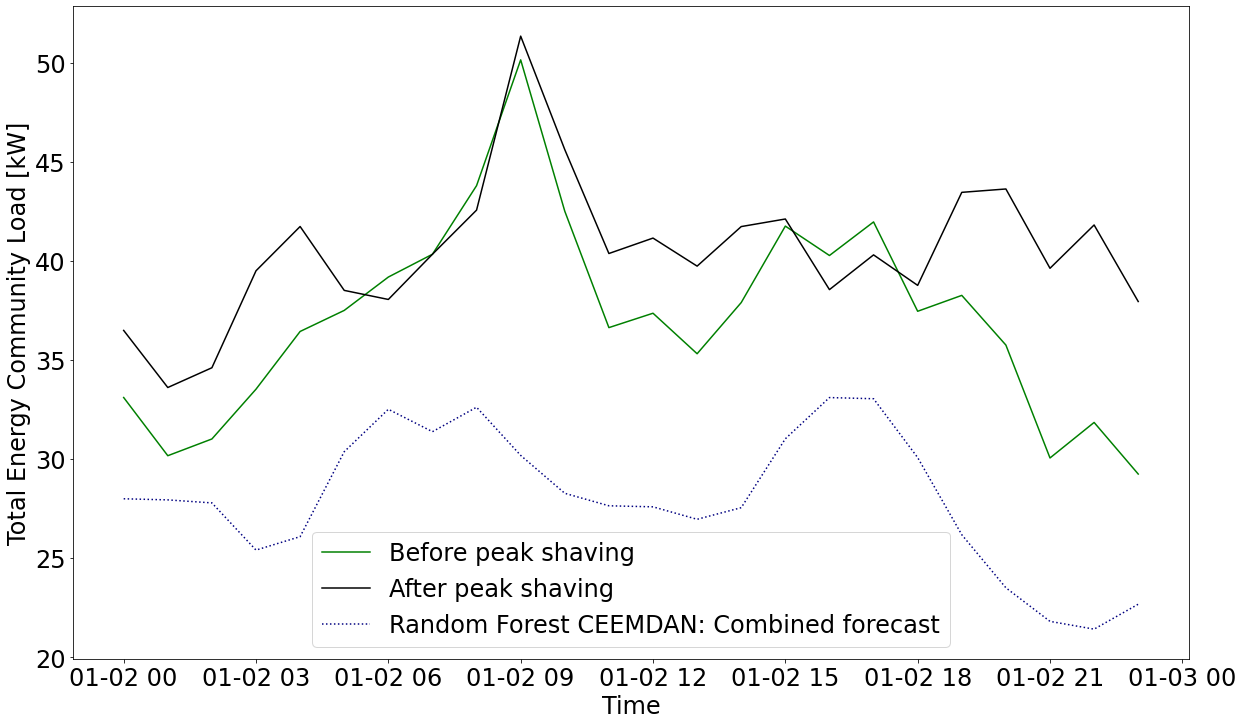

In [139]:
# plotting worst day for worst model RF CEEMDAN

top_load_day = after_peakshaving["Real Load"].nlargest(1).index.date
max_load_date = top_load_day[0]

highest_day_df = after_peakshaving[after_peakshaving.index.date == max_load_date]
total_comparison_highest_day = total_comparison[total_comparison.index.date == max_load_date]

highest_day_df["Random Forest CEEMDAN: Combined before peak shaving"] = total_comparison_highest_day["Random Forest CEEMDAN: Combined"].values


plt.figure(figsize=(20, 12))
highest_day_df["Random Forest CEEMDAN Combined before peak shaving"] = total_comparison_highest_day["Random Forest CEEMDAN: Combined"].values

highest_day_df = highest_day_df.applymap(lambda x: x/1000)

plt.plot(highest_day_df['Real Load'], color='green', label='Before peak shaving')
plt.plot(highest_day_df['Random Forest CEEMDAN: Combined after peak shaving'], color='black', label='After peak shaving')
plt.plot(highest_day_df['Random Forest CEEMDAN: Combined before peak shaving'], color='navy', linestyle='dotted', label='Random Forest CEEMDAN: Combined forecast')
plt.xlabel('Time')
plt.ylabel('Total Energy Community Load [kW]')
plt.legend()
plt.savefig("./results/peakshaving_rf.pdf", bbox_inches='tight')

plt.show()


<ipython-input-140-1d86600df1a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_day_df["Transformer: Combined Before Peakshaving"] = total_comparison_highest_day["Transformer: Combined"].values


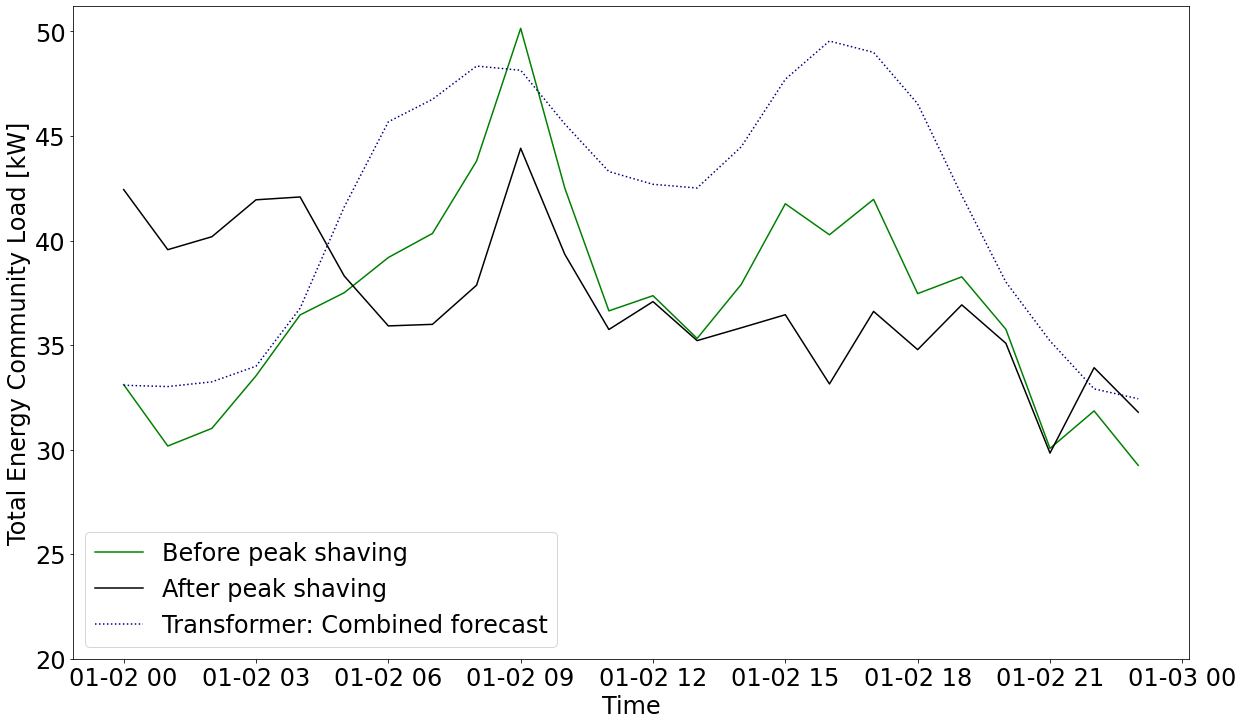

In [140]:
# plotting worst day for transformer

top_load_day = after_peakshaving["Real Load"].nlargest(1).index.date
max_load_date = top_load_day[0]

highest_day_df = after_peakshaving[after_peakshaving.index.date == max_load_date]
total_comparison_highest_day = total_comparison[total_comparison.index.date == max_load_date]
highest_day_df["Transformer: Combined Before Peakshaving"] = total_comparison_highest_day["Transformer: Combined"].values



plt.figure(figsize=(20, 12))

highest_day_df = highest_day_df.applymap(lambda x: x/1000)

plt.plot(highest_day_df['Real Load'], color='green', label='Before peak shaving')
plt.plot(highest_day_df['Transformer: Combined after peak shaving'], color='black', label='After peak shaving')
plt.plot(highest_day_df['Transformer: Combined Before Peakshaving'], color='navy', linestyle='dotted', label='Transformer: Combined forecast')
plt.xlabel('Time')
plt.ylabel('Total Energy Community Load [kW]')
plt.legend()
plt.ylim(bottom=20)
plt.savefig("./results/peakshaving_transformer.pdf", bbox_inches='tight')

plt.show()


In [141]:
after_peakshaving

,Real Load,Random Forest: Combined after peak shaving,Random Forest: Separate after peak shaving,Real Load after peak shaving,Random Forest CEEMDAN: Combined after peak shaving,Random Forest CEEMDAN: Separate after peak shaving,XGB: Combined after peak shaving,XGB: Separate after peak shaving,XGB CEEMDAN: Combined after peak shaving,XGB CEEMDAN: Separate after peak shaving,LSTM: Combined after peak shaving,LSTM: Separate after peak shaving,LSTM CEEMDAN: Combined after peak shaving,LSTM CEEMDAN: Separate after peak shaving,Transformer: Combined after peak shaving,Transformer: Separate after peak shaving,Transformer CEEMDAN: Combined after peak shaving,Transformer CEEMDAN: Separate after peak shaving
date,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624,36831.395624
2020-01-01 01:00:00+00:00,34176.756428,41675.136648,43791.080844,38854.578872,40896.689573,41147.370529,42462.434119,45048.610245,46719.07507,44926.570134,39905.831765,40762.359909,38553.073178,38916.092714,45131.596169,42451.608248,39970.88957,39202.661728
2020-01-01 02:00:00+00:00,28998.475352,34920.849745,37638.428064,38854.578872,35633.998382,35230.778883,35206.942106,37058.858465,39942.686572,39713.121089,35524.554595,36058.04563,33041.30079,33560.377201,39224.689117,36430.922326,35376.9166,33676.577247
2020-01-01 03:00:00+00:00,33044.329155,37554.02056,41601.114659,38854.578872,38458.932389,37945.130392,38055.424815,41164.891956,41647.255219,41429.213173,37935.185742,39490.498066,37735.786273,36056.405803,42603.47456,39959.509344,39812.338029,37420.091755
2020-01-01 04:00:00+00:00,29459.149099,32677.767735,36498.162129,38854.578872,34466.796558,35321.739064,32965.98304,34117.36815,36784.89157,35705.779212,35131.279123,35557.547991,34483.149604,32939.032706,36130.607004,34096.810734,34903.176773,31943.933123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,30587.419588,29192.948292,29167.560714,29078.250903,28012.508465,27941.450484,29469.475443,29576.07166,28511.745691,29206.058537,28898.959065,28690.846726,29487.973799,28301.748175,28498.745826,28393.019807,28591.164173,28478.160757
2020-12-31 20:00:00+00:00,24249.875910,23552.640262,23539.946473,23495.291568,22962.420349,22926.891358,23690.903837,23744.201946,23212.038961,23559.195384,23405.645649,23301.589479,23700.153015,23107.040203,23205.539029,23152.67602,23251.748203,23195.246494
2020-12-31 21:00:00+00:00,24439.704660,24091.086836,24084.739942,24062.412489,23795.976879,23778.212384,24160.218624,24186.867678,23920.786186,24094.364397,24017.589529,23965.561445,24164.843213,23868.286807,23917.53622,23891.104715,23940.640806,23912.389952


<AxesSubplot: title={'center': 'Peak reduction based on forecast'}, xlabel='Peak reduction [kW]'>

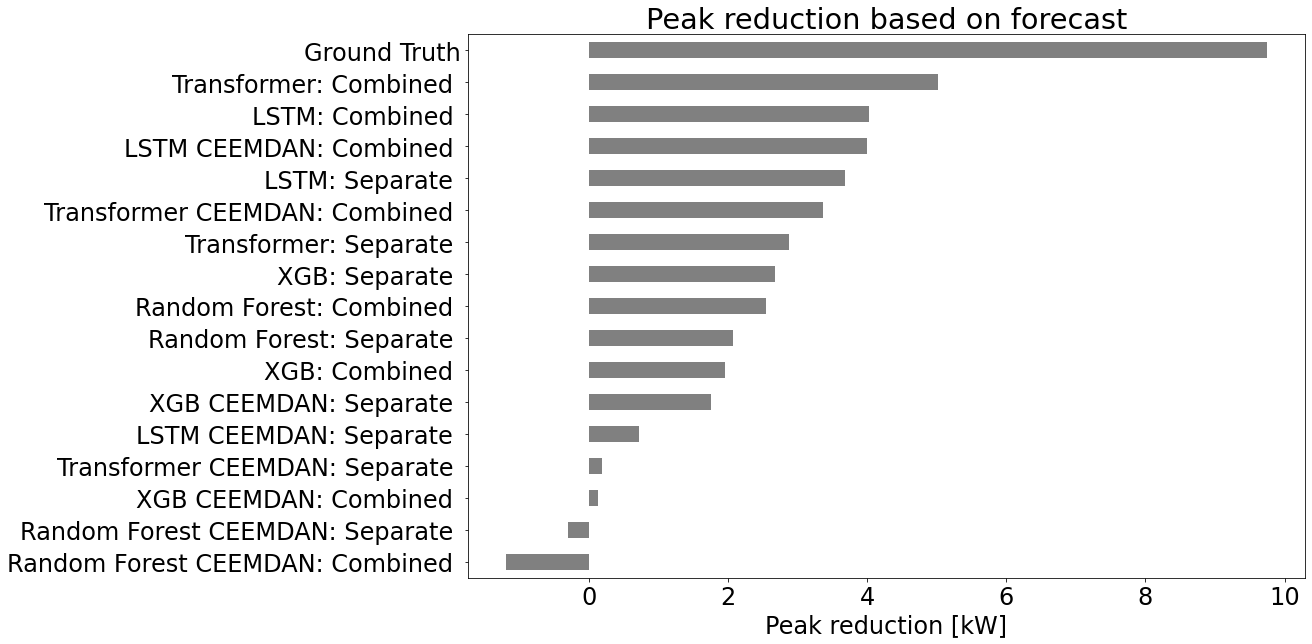

In [142]:
# Calculate Peak Reductions
plt.rcParams.update({'font.size': 24})
after_peakshaving.columns = [col.replace("after peak shaving","") for col in after_peakshaving.columns]

peak_reductions = (after_peakshaving.max()["Real Load"]-after_peakshaving.max()).sort_values(ascending=True)
peak_reductions = peak_reductions.apply(lambda x: x/1000)
peak_reductions = peak_reductions.rename({"Real Load ": "Ground Truth"})
peak_reductions =peak_reductions.drop("Real Load")
peak_reductions.plot.barh(color="grey",figsize=(15,10),title="Peak reduction based on forecast",xlabel="Peak reduction [kW]")



In [143]:
peak_reductions

Random Forest CEEMDAN: Combined    -1.196304
Random Forest CEEMDAN: Separate    -0.299592
XGB CEEMDAN: Combined               0.135348
Transformer CEEMDAN: Separate       0.191935
LSTM CEEMDAN: Separate              0.716220
XGB CEEMDAN: Separate               1.750722
XGB: Combined                       1.957748
Random Forest: Separate             2.071538
Random Forest: Combined             2.539668
XGB: Separate                       2.671149
Transformer: Separate               2.868251
Transformer CEEMDAN: Combined       3.356734
LSTM: Separate                      3.684946
LSTM CEEMDAN: Combined              3.989679
LSTM: Combined                      4.024542
Transformer: Combined               5.015677
Ground Truth                        9.744621
dtype: float64

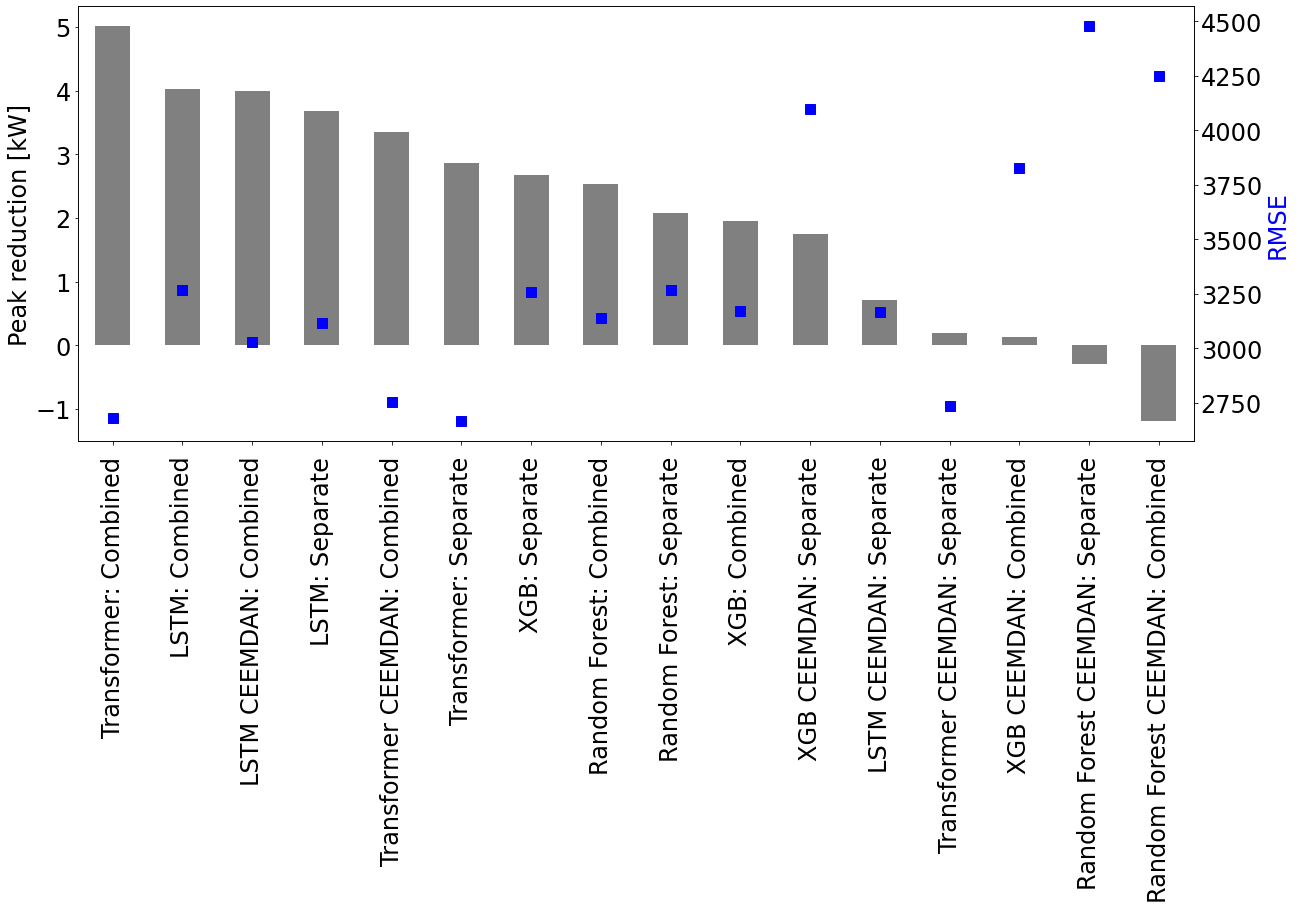

In [144]:
# retrieving the peak reduction, as well as the rmse, ordering alphabetically
reduction_series = peak_reductions.sort_index()[1:]
rmse_series = total_results.T["RMSE"].sort_index()
df_compare = pd.DataFrame()
df_compare["Peak reduction [kW]"] = reduction_series
df_compare["RMSE"] = rmse_series.values
df_compare.sort_values("Peak reduction [kW]",inplace=True,ascending=False)

fig, ax = plt.subplots(figsize=(20, 8))
df_compare["Peak reduction [kW]"].plot(kind='bar', color='grey', ax=ax)
ax.set_ylabel('Peak reduction [kW]')
ax2 = ax.twinx()
ax2.set_ylabel('RMSE',color="blue")
ax2.plot(df_compare.index, df_compare["RMSE"], 's', color='blue', markersize=10, label='RMSE')


In [99]:
reduction_series

LSTM CEEMDAN: Combined              3.989679
LSTM CEEMDAN: Separate              0.716220
LSTM: Combined                      4.980534
LSTM: Separate                      2.322288
Random Forest CEEMDAN: Combined    -1.196304
Random Forest CEEMDAN: Separate    -0.299592
Random Forest: Combined             2.539668
Random Forest: Separate             2.071538
Transformer CEEMDAN: Combined       3.356734
Transformer CEEMDAN: Separate       0.191935
Transformer: Combined               5.671269
Transformer: Separate               3.642506
XGB CEEMDAN: Combined               0.135348
XGB CEEMDAN: Separate               1.750722
XGB: Combined                       1.957748
XGB: Separate                       2.671149
dtype: float64

In [100]:
rmse_series

LSTM CEEMDAN: Combined             3029.791322
LSTM CEEMDAN: Separate             3167.111943
LSTM: Combined                     3131.561099
LSTM: Separate                     3330.408660
Random Forest CEEMDAN: Combined    4247.912603
Random Forest CEEMDAN: Separate    4478.732110
Random Forest: Combined            3137.000265
Random Forest: Separate            3269.301888
Transformer CEEMDAN: Combined      2754.216403
Transformer CEEMDAN: Separate      2736.401988
Transformer: Combined              2743.592245
Transformer: Separate              2776.966373
XGB CEEMDAN: Combined              3827.778104
XGB CEEMDAN: Separate              4097.766837
XGB: Combined                      3168.893192
XGB: Separate                      3256.327808
Name: RMSE, dtype: float64